# 05 Crash course on Neural Nets

## Skip this lecture if you think you are a Deep Learning master

#### 👉 Let's train a few neural network models in a supervised setting.

#### 👉 In Supervised Machine Learning you have input features and target values. And the goal is to find the *right* mapping between input features and target values.

#### 👉Neural networks are usually highly-parametric models that are able to fit complex patterns between the input features and the target.

#### 👉 The type of neural network we will use is a Multi Layer Perceptron (MLP). MLPs are stacks of linear models, interleaved with *activation functions.*

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

In [7]:
import gym
env = gym.make('CartPole-v1')

# 1. Data

Steps to generate the train data and test data we will need to build the neural network, and to evaluate it.

## 1.1 Download the agent parameters from Google Drive 📩

In [8]:
from src.supervised_ml import download_agent_parameters

path_to_agent_data = download_agent_parameters()

Downloading...
From: https://docs.google.com/uc?export=download&id=1KH4ANx84PMmCY6H4FoUnkBLVC1z1A6W6
To: /Users/paulabartabajo/src/online-courses/hands-on-rl/03_cart_pole/saved_agents/CartPole-v1/gdrive_agent.zip
100%|█████████████████████████████████████████████████████████████████████████| 255k/255k [00:00<00:00, 2.39MB/s]


## 1.2 Create `QAgent` object from the parameters (and hyper-parameters) we just downloaded

In [9]:
from src.q_agent import QAgent

agent = QAgent.load_from_disk(env, path=path_to_agent_data)

67,586 parameters


## 1.3 Let's check it works like a charm

In [47]:
from src.utils import set_seed
set_seed(env, 1234)

from src.loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.0 # 100% greedy strategy
)

100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.40it/s]


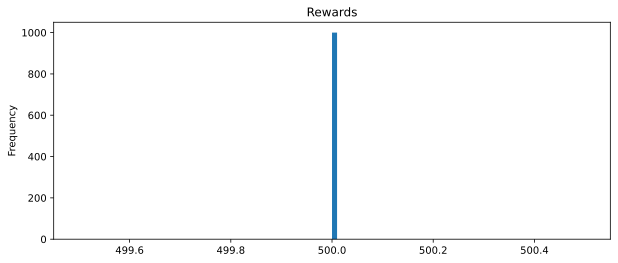

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## 1.4 Generate train data -->  `train.csv`

In [10]:
from src.supervised_ml import generate_state_action_data
from src.config import DATA_SUPERVISED_ML

n_samples_train = 1000
path_to_train_data = DATA_SUPERVISED_ML / 'train.csv'
env.seed(0)

# we let the agent interact with the environment until we have
# collected enough pairs (state, action)
generate_state_action_data(env, agent,
                           n_samples=n_samples_train,
                           path=path_to_train_data)

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5710.11it/s]


## 1.5 Generate test data --> `test.csv`

In [11]:
# test data
n_samples_test = 1000
path_to_test_data = DATA_SUPERVISED_ML / 'test.csv'

# Very important to use another seed than for the
# train set
env.seed(1)

generate_state_action_data(env, agent, 
                           n_samples=n_samples_test,
                           path=path_to_test_data)

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6252.54it/s]


-----

# 2. Let's train a few neural networks

#### 👉We will try different neural network architecture, to see which one works best for our problem.
#### 👉 Finding the right architecture is not an easy problem. This is one of the hard parts of training neural networks.

## Load `train.csv` and `test.csv` into 🐼

In [44]:
import pandas as pd

train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)

## PyTorch datasets

In [ ]:
from torch.utils.data import Dataset

class OptimalPolicyDataset(Dataset):

    def __init__(self, X: pd.DataFrame, y: pd.Series):
        self.X = X
        self.y = y

    def __len__(self):
        """
        Returns number of samples in the data
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns the features and label
        of sample number `idx`
        """
        return self.X.iloc[idx].values, self.y.iloc[idx]

In [13]:
# split features and labels
X_train = train_data[['s0', 's1', 's2', 's3']]
y_train = train_data['action']
X_test = test_data[['s0', 's1', 's2', 's3']]
y_test = test_data['action']

# PyTorch datasets
from src.supervised_ml import OptimalPolicyDataset
train_dataset = OptimalPolicyDataset(X_train, y_train)
test_dataset = OptimalPolicyDataset(X_test, y_test)

## PyTorch dataloaders

In [14]:
BATCH_SIZE = 64

# PyTorch dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

## Loss function
#### 👉 The cross entropy is a common choice for classification problems

In [22]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

## Model 0: Baseline

In [41]:
train_data['action'].value_counts()

0    501
1    499
Name: action, dtype: int64

In [43]:
test_data['action'].value_counts()

1    500
0    500
Name: action, dtype: int64

## Model 1: Linear model

### Model architecture 📐🏗️

In [28]:
import torch
from src.model_factory import get_model, count_parameters

# linear model --> no hidden_layers (hidden_layers = None)
model = get_model(input_dim=4, output_dim=2, hidden_layers=None)

# send the model to GPU if you have one.
# GPUs have a very fast implementation of matrix multiplication,
# which is the key operation to propagate inputs to outputs
# in most neural network architectures
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

10 parameters
Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/linear_model_sml.jpg?raw=true)

### Train loop 🏋️

In [29]:
# Tensoboard logger
import time
from src.supervised_ml import get_tensorboard_writer
run_name = f'linear/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

# train_val_loop runs a full pass on the given data
# (either train or test) and logs metrics to tensorboard
from src.supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model,
                                    criterion,
                                    optimizer,
                                    tensorboard_writer)


# call train_val_loop 150 times for training,
# and 150 times for evaluating.
N_EPOCHS = 150
for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True,
                   dataloader=train_dataloader,
                   epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False,
                       dataloader=test_dataloader,
                       epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.6790 - accuracy: 0.5820: 100%|████████████████████████████████| 16/16 [00:00<00:00, 114.85it/s]


----------


Epoch 1 - loss: 0.6746 - accuracy: 0.5840: 100%|████████████████████████████████| 16/16 [00:00<00:00, 113.52it/s]


----------


Epoch 2 - loss: 0.6710 - accuracy: 0.5900: 100%|████████████████████████████████| 16/16 [00:00<00:00, 104.91it/s]


----------


Epoch 3 - loss: 0.6682 - accuracy: 0.5990: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 74.20it/s]


----------


Epoch 4 - loss: 0.6659 - accuracy: 0.6020: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 83.77it/s]


----------


Epoch 5 - loss: 0.6638 - accuracy: 0.6040: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 74.24it/s]


----------


Epoch 6 - loss: 0.6619 - accuracy: 0.6160: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 90.81it/s]


----------


Epoch 7 - loss: 0.6602 - accuracy: 0.6200: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 44.79it/s]


----------


Epoch 8 - loss: 0.6586 - accuracy: 0.6210: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 67.47it/s]


----------


Epoch 9 - loss: 0.6569 - accuracy: 0.6270: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 92.27it/s]


----------


Epoch 10 - loss: 0.6554 - accuracy: 0.6310: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.53it/s]


----------


Epoch 11 - loss: 0.6539 - accuracy: 0.6320: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.77it/s]


----------


Epoch 12 - loss: 0.6525 - accuracy: 0.6340: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.64it/s]


----------


Epoch 13 - loss: 0.6512 - accuracy: 0.6340: 100%|████████████████████████████████| 16/16 [00:00<00:00, 76.47it/s]


----------


Epoch 14 - loss: 0.6499 - accuracy: 0.6400: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.73it/s]


----------


Epoch 15 - loss: 0.6485 - accuracy: 0.6440: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.30it/s]


----------


Epoch 16 - loss: 0.6473 - accuracy: 0.6470: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.67it/s]


----------


Epoch 17 - loss: 0.6461 - accuracy: 0.6520: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.06it/s]


----------


Epoch 18 - loss: 0.6449 - accuracy: 0.6500: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.36it/s]


----------


Epoch 19 - loss: 0.6438 - accuracy: 0.6510: 100%|████████████████████████████████| 16/16 [00:00<00:00, 73.72it/s]


----------


Epoch 20 - loss: 0.6427 - accuracy: 0.6530: 100%|████████████████████████████████| 16/16 [00:00<00:00, 87.35it/s]


----------


Epoch 21 - loss: 0.6416 - accuracy: 0.6550: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.62it/s]


----------


Epoch 22 - loss: 0.6406 - accuracy: 0.6540: 100%|████████████████████████████████| 16/16 [00:00<00:00, 93.55it/s]


----------


Epoch 23 - loss: 0.6396 - accuracy: 0.6560: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.34it/s]


----------


Epoch 24 - loss: 0.6387 - accuracy: 0.6590: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.23it/s]


----------


Epoch 25 - loss: 0.6377 - accuracy: 0.6610: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.17it/s]


----------


Epoch 26 - loss: 0.6368 - accuracy: 0.6620: 100%|████████████████████████████████| 16/16 [00:00<00:00, 95.49it/s]


----------


Epoch 27 - loss: 0.6359 - accuracy: 0.6620: 100%|███████████████████████████████| 16/16 [00:00<00:00, 102.11it/s]


----------


Epoch 28 - loss: 0.6350 - accuracy: 0.6640: 100%|███████████████████████████████| 16/16 [00:00<00:00, 104.43it/s]


----------


Epoch 29 - loss: 0.6342 - accuracy: 0.6640: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.11it/s]


----------


Epoch 30 - loss: 0.6333 - accuracy: 0.6710: 100%|████████████████████████████████| 16/16 [00:00<00:00, 96.23it/s]


----------


Epoch 31 - loss: 0.6325 - accuracy: 0.6700: 100%|████████████████████████████████| 16/16 [00:00<00:00, 98.98it/s]


----------


Epoch 32 - loss: 0.6317 - accuracy: 0.6720: 100%|████████████████████████████████| 16/16 [00:00<00:00, 90.91it/s]


----------


Epoch 33 - loss: 0.6310 - accuracy: 0.6720: 100%|████████████████████████████████| 16/16 [00:00<00:00, 98.91it/s]


----------


Epoch 34 - loss: 0.6302 - accuracy: 0.6760: 100%|███████████████████████████████| 16/16 [00:00<00:00, 104.47it/s]


----------


Epoch 35 - loss: 0.6295 - accuracy: 0.6750: 100%|███████████████████████████████| 16/16 [00:00<00:00, 106.68it/s]


----------


Epoch 36 - loss: 0.6287 - accuracy: 0.6770: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.83it/s]


----------


Epoch 37 - loss: 0.6280 - accuracy: 0.6750: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.69it/s]


----------


Epoch 38 - loss: 0.6274 - accuracy: 0.6730: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.71it/s]


----------


Epoch 39 - loss: 0.6267 - accuracy: 0.6780: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.27it/s]


----------


Epoch 40 - loss: 0.6261 - accuracy: 0.6790: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.45it/s]


----------


Epoch 41 - loss: 0.6254 - accuracy: 0.6790: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.66it/s]


----------


Epoch 42 - loss: 0.6248 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 100.64it/s]


----------


Epoch 43 - loss: 0.6242 - accuracy: 0.6800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 92.86it/s]


----------


Epoch 44 - loss: 0.6236 - accuracy: 0.6820: 100%|████████████████████████████████| 16/16 [00:00<00:00, 97.96it/s]


----------


Epoch 45 - loss: 0.6230 - accuracy: 0.6850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 97.62it/s]


----------


Epoch 46 - loss: 0.6225 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.54it/s]


----------


Epoch 47 - loss: 0.6219 - accuracy: 0.6820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 100.32it/s]


----------


Epoch 48 - loss: 0.6214 - accuracy: 0.6850: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.50it/s]


----------


Epoch 49 - loss: 0.6209 - accuracy: 0.6890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.00it/s]


----------


Epoch 50 - loss: 0.6203 - accuracy: 0.6830: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.95it/s]


----------


Epoch 51 - loss: 0.6198 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 113.43it/s]


----------


Epoch 52 - loss: 0.6193 - accuracy: 0.6830: 100%|███████████████████████████████| 16/16 [00:00<00:00, 113.95it/s]


----------


Epoch 53 - loss: 0.6189 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 103.40it/s]


----------


Epoch 54 - loss: 0.6184 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 113.15it/s]


----------


Epoch 55 - loss: 0.6179 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 117.51it/s]


----------


Epoch 56 - loss: 0.6174 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 118.23it/s]


----------


Epoch 57 - loss: 0.6170 - accuracy: 0.6860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 116.78it/s]


----------


Epoch 58 - loss: 0.6165 - accuracy: 0.6830: 100%|███████████████████████████████| 16/16 [00:00<00:00, 115.39it/s]


----------


Epoch 59 - loss: 0.6161 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 117.84it/s]


----------


Epoch 60 - loss: 0.6157 - accuracy: 0.6860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 120.14it/s]


----------


Epoch 61 - loss: 0.6153 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 121.22it/s]


----------


Epoch 62 - loss: 0.6148 - accuracy: 0.6820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 122.00it/s]


----------


Epoch 63 - loss: 0.6145 - accuracy: 0.6820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 122.42it/s]


----------


Epoch 64 - loss: 0.6141 - accuracy: 0.6830: 100%|███████████████████████████████| 16/16 [00:00<00:00, 121.68it/s]


----------


Epoch 65 - loss: 0.6137 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 122.72it/s]


----------


Epoch 66 - loss: 0.6133 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 126.54it/s]


----------


Epoch 67 - loss: 0.6129 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 124.67it/s]


----------


Epoch 68 - loss: 0.6125 - accuracy: 0.6860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 126.07it/s]


----------


Epoch 69 - loss: 0.6121 - accuracy: 0.6850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.37it/s]


----------


Epoch 70 - loss: 0.6118 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.90it/s]


----------


Epoch 71 - loss: 0.6114 - accuracy: 0.6850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 67.44it/s]


----------


Epoch 72 - loss: 0.6111 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 67.22it/s]


----------


Epoch 73 - loss: 0.6107 - accuracy: 0.6850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 94.40it/s]


----------


Epoch 74 - loss: 0.6104 - accuracy: 0.6870: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.67it/s]


----------


Epoch 75 - loss: 0.6101 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 90.03it/s]


----------


Epoch 76 - loss: 0.6097 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.82it/s]


----------


Epoch 77 - loss: 0.6094 - accuracy: 0.6850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.96it/s]


----------


Epoch 78 - loss: 0.6091 - accuracy: 0.6840: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.69it/s]


----------


Epoch 79 - loss: 0.6087 - accuracy: 0.6850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.19it/s]


----------


Epoch 80 - loss: 0.6084 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 88.91it/s]


----------


Epoch 81 - loss: 0.6081 - accuracy: 0.6870: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.54it/s]


----------


Epoch 82 - loss: 0.6078 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 87.55it/s]


----------


Epoch 83 - loss: 0.6075 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.60it/s]


----------


Epoch 84 - loss: 0.6072 - accuracy: 0.6860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.58it/s]


----------


Epoch 85 - loss: 0.6069 - accuracy: 0.6800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 88.61it/s]


----------


Epoch 86 - loss: 0.6066 - accuracy: 0.6780: 100%|████████████████████████████████| 16/16 [00:00<00:00, 88.70it/s]


----------


Epoch 87 - loss: 0.6063 - accuracy: 0.6730: 100%|████████████████████████████████| 16/16 [00:00<00:00, 87.92it/s]


----------


Epoch 88 - loss: 0.6060 - accuracy: 0.6740: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.88it/s]


----------


Epoch 89 - loss: 0.6057 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.82it/s]


----------


Epoch 90 - loss: 0.6055 - accuracy: 0.6780: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.05it/s]


----------


Epoch 91 - loss: 0.6052 - accuracy: 0.6780: 100%|████████████████████████████████| 16/16 [00:00<00:00, 94.16it/s]


----------


Epoch 92 - loss: 0.6049 - accuracy: 0.6770: 100%|████████████████████████████████| 16/16 [00:00<00:00, 93.64it/s]


----------


Epoch 93 - loss: 0.6046 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 93.41it/s]


----------


Epoch 94 - loss: 0.6044 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.94it/s]


----------


Epoch 95 - loss: 0.6041 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 97.89it/s]


----------


Epoch 96 - loss: 0.6038 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 97.01it/s]


----------


Epoch 97 - loss: 0.6036 - accuracy: 0.6750: 100%|████████████████████████████████| 16/16 [00:00<00:00, 98.11it/s]


----------


Epoch 98 - loss: 0.6033 - accuracy: 0.6750: 100%|████████████████████████████████| 16/16 [00:00<00:00, 98.38it/s]


----------


Epoch 99 - loss: 0.6030 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 96.83it/s]


----------


Epoch 100 - loss: 0.6028 - accuracy: 0.6760: 100%|███████████████████████████████| 16/16 [00:00<00:00, 96.02it/s]


----------


Epoch 101 - loss: 0.6025 - accuracy: 0.6780: 100%|███████████████████████████████| 16/16 [00:00<00:00, 93.38it/s]


----------


Epoch 102 - loss: 0.6023 - accuracy: 0.6770: 100%|███████████████████████████████| 16/16 [00:00<00:00, 94.72it/s]


----------


Epoch 103 - loss: 0.6021 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 92.58it/s]


----------


Epoch 104 - loss: 0.6018 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 87.46it/s]


----------


Epoch 105 - loss: 0.6016 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 90.24it/s]


----------


Epoch 106 - loss: 0.6013 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 89.68it/s]


----------


Epoch 107 - loss: 0.6011 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 91.80it/s]


----------


Epoch 108 - loss: 0.6008 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 93.20it/s]


----------


Epoch 109 - loss: 0.6006 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 94.03it/s]


----------


Epoch 110 - loss: 0.6004 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 96.39it/s]


----------


Epoch 111 - loss: 0.6001 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 98.66it/s]


----------


Epoch 112 - loss: 0.5999 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 97.74it/s]


----------


Epoch 113 - loss: 0.5997 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 80.29it/s]


----------


Epoch 114 - loss: 0.5995 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.60it/s]


----------


Epoch 115 - loss: 0.5992 - accuracy: 0.6800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 87.84it/s]


----------


Epoch 116 - loss: 0.5990 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.68it/s]


----------


Epoch 117 - loss: 0.5988 - accuracy: 0.6790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 75.44it/s]


----------


Epoch 118 - loss: 0.5986 - accuracy: 0.6820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 61.14it/s]


----------


Epoch 119 - loss: 0.5984 - accuracy: 0.6830: 100%|███████████████████████████████| 16/16 [00:00<00:00, 68.59it/s]


----------


Epoch 120 - loss: 0.5981 - accuracy: 0.6820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.37it/s]


----------


Epoch 121 - loss: 0.5979 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 72.78it/s]


----------


Epoch 122 - loss: 0.5977 - accuracy: 0.6840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.25it/s]


----------


Epoch 123 - loss: 0.5975 - accuracy: 0.6830: 100%|███████████████████████████████| 16/16 [00:00<00:00, 71.50it/s]


----------


Epoch 124 - loss: 0.5973 - accuracy: 0.6860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 64.48it/s]


----------


Epoch 125 - loss: 0.5971 - accuracy: 0.6850: 100%|███████████████████████████████| 16/16 [00:00<00:00, 47.32it/s]


----------


Epoch 126 - loss: 0.5969 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 28.55it/s]


----------


Epoch 127 - loss: 0.5967 - accuracy: 0.6850: 100%|███████████████████████████████| 16/16 [00:00<00:00, 53.18it/s]


----------


Epoch 128 - loss: 0.5965 - accuracy: 0.6860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 57.07it/s]


----------


Epoch 129 - loss: 0.5963 - accuracy: 0.6890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 29.07it/s]


----------


Epoch 130 - loss: 0.5961 - accuracy: 0.6860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 75.44it/s]


----------


Epoch 131 - loss: 0.5959 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 59.67it/s]


----------


Epoch 132 - loss: 0.5957 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 57.64it/s]


----------


Epoch 133 - loss: 0.5954 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 72.26it/s]


----------


Epoch 134 - loss: 0.5952 - accuracy: 0.6900: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.07it/s]


----------


Epoch 135 - loss: 0.5950 - accuracy: 0.6890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 75.03it/s]


----------


Epoch 136 - loss: 0.5949 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 80.48it/s]


----------


Epoch 137 - loss: 0.5947 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 85.06it/s]


----------


Epoch 138 - loss: 0.5945 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 87.06it/s]


----------


Epoch 139 - loss: 0.5943 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 93.34it/s]


----------


Epoch 140 - loss: 0.5941 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 96.82it/s]


----------


Epoch 141 - loss: 0.5939 - accuracy: 0.6870: 100%|██████████████████████████████| 16/16 [00:00<00:00, 101.40it/s]


----------


Epoch 142 - loss: 0.5937 - accuracy: 0.6880: 100%|██████████████████████████████| 16/16 [00:00<00:00, 100.93it/s]


----------


Epoch 143 - loss: 0.5935 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 81.01it/s]


----------


Epoch 144 - loss: 0.5934 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.31it/s]


----------


Epoch 145 - loss: 0.5932 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 84.01it/s]


----------


Epoch 146 - loss: 0.5930 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.93it/s]


----------


Epoch 147 - loss: 0.5928 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 99.40it/s]


----------


Epoch 148 - loss: 0.5927 - accuracy: 0.6880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 95.54it/s]


----------


Epoch 149 - loss: 0.5925 - accuracy: 0.6870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 99.32it/s]

----------


-------

## Model 2: Neural network with 1 hidden layer

### Model architecture 📐🏗️

In [30]:
model = get_model(input_dim=4, output_dim=2, hidden_layers=[256])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

1,794 parameters
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/nn_1_hidden_layer_sml.jpg?raw=true)

### Train loop 🏋️

In [31]:
# Tensoboard logger
import time
from src.supervised_ml import get_tensorboard_writer

run_name = f'[256]/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

from src.supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model, criterion, optimizer, tensorboard_writer)

N_EPOCHS = 150

for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True, dataloader=train_dataloader, epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False, dataloader=test_dataloader, epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.6636 - accuracy: 0.6300: 100%|████████████████████████████████| 16/16 [00:00<00:00, 122.02it/s]


----------


Epoch 1 - loss: 0.6443 - accuracy: 0.6400: 100%|████████████████████████████████| 16/16 [00:00<00:00, 121.70it/s]


----------


Epoch 2 - loss: 0.6309 - accuracy: 0.6370: 100%|████████████████████████████████| 16/16 [00:00<00:00, 121.70it/s]


----------


Epoch 3 - loss: 0.6244 - accuracy: 0.6710: 100%|████████████████████████████████| 16/16 [00:00<00:00, 111.66it/s]


----------


Epoch 4 - loss: 0.6146 - accuracy: 0.6410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 119.83it/s]


----------


Epoch 5 - loss: 0.6057 - accuracy: 0.6850: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 83.29it/s]


----------


Epoch 6 - loss: 0.5987 - accuracy: 0.6690: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 86.30it/s]


----------


Epoch 7 - loss: 0.5909 - accuracy: 0.7060: 100%|████████████████████████████████| 16/16 [00:00<00:00, 122.50it/s]


----------


Epoch 8 - loss: 0.5851 - accuracy: 0.6980: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 76.02it/s]


----------


Epoch 9 - loss: 0.5780 - accuracy: 0.7080: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 74.64it/s]


----------


Epoch 10 - loss: 0.5710 - accuracy: 0.7160: 100%|███████████████████████████████| 16/16 [00:00<00:00, 106.83it/s]


----------


Epoch 11 - loss: 0.5651 - accuracy: 0.7190: 100%|███████████████████████████████| 16/16 [00:00<00:00, 116.55it/s]


----------


Epoch 12 - loss: 0.5593 - accuracy: 0.7260: 100%|███████████████████████████████| 16/16 [00:00<00:00, 122.45it/s]


----------


Epoch 13 - loss: 0.5547 - accuracy: 0.7200: 100%|███████████████████████████████| 16/16 [00:00<00:00, 103.12it/s]


----------


Epoch 14 - loss: 0.5497 - accuracy: 0.7290: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.57it/s]


----------


Epoch 15 - loss: 0.5422 - accuracy: 0.7340: 100%|███████████████████████████████| 16/16 [00:00<00:00, 119.06it/s]


----------


Epoch 16 - loss: 0.5375 - accuracy: 0.7400: 100%|████████████████████████████████| 16/16 [00:00<00:00, 97.79it/s]


----------


Epoch 17 - loss: 0.5347 - accuracy: 0.7300: 100%|████████████████████████████████| 16/16 [00:00<00:00, 92.03it/s]


----------


Epoch 18 - loss: 0.5348 - accuracy: 0.7490: 100%|███████████████████████████████| 16/16 [00:00<00:00, 104.70it/s]


----------


Epoch 19 - loss: 0.5301 - accuracy: 0.7400: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.81it/s]


----------


Epoch 20 - loss: 0.5208 - accuracy: 0.7430: 100%|████████████████████████████████| 16/16 [00:00<00:00, 97.24it/s]


----------


Epoch 21 - loss: 0.5156 - accuracy: 0.7470: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.56it/s]


----------


Epoch 22 - loss: 0.5125 - accuracy: 0.7550: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.60it/s]


----------


Epoch 23 - loss: 0.5086 - accuracy: 0.7550: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.63it/s]


----------


Epoch 24 - loss: 0.5044 - accuracy: 0.7600: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.09it/s]


----------


Epoch 25 - loss: 0.5018 - accuracy: 0.7560: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.93it/s]


----------


Epoch 26 - loss: 0.4981 - accuracy: 0.7650: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.03it/s]


----------


Epoch 27 - loss: 0.4962 - accuracy: 0.7600: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.20it/s]


----------


Epoch 28 - loss: 0.4918 - accuracy: 0.7650: 100%|████████████████████████████████| 16/16 [00:00<00:00, 95.13it/s]


----------


Epoch 29 - loss: 0.4901 - accuracy: 0.7650: 100%|████████████████████████████████| 16/16 [00:00<00:00, 74.67it/s]


----------


Epoch 30 - loss: 0.4874 - accuracy: 0.7710: 100%|████████████████████████████████| 16/16 [00:00<00:00, 78.85it/s]


----------


Epoch 31 - loss: 0.4851 - accuracy: 0.7700: 100%|████████████████████████████████| 16/16 [00:00<00:00, 74.32it/s]


----------


Epoch 32 - loss: 0.4836 - accuracy: 0.7660: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.65it/s]


----------


Epoch 33 - loss: 0.4811 - accuracy: 0.7710: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.13it/s]


----------


Epoch 34 - loss: 0.4778 - accuracy: 0.7800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 79.91it/s]


----------


Epoch 35 - loss: 0.4749 - accuracy: 0.7720: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.85it/s]


----------


Epoch 36 - loss: 0.4709 - accuracy: 0.7850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.83it/s]


----------


Epoch 37 - loss: 0.4753 - accuracy: 0.7740: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.09it/s]


----------


Epoch 38 - loss: 0.4667 - accuracy: 0.7860: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.99it/s]


----------


Epoch 39 - loss: 0.4653 - accuracy: 0.7740: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.46it/s]


----------


Epoch 40 - loss: 0.4632 - accuracy: 0.7880: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.57it/s]


----------


Epoch 41 - loss: 0.4614 - accuracy: 0.7900: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.43it/s]


----------


Epoch 42 - loss: 0.4590 - accuracy: 0.7820: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.16it/s]


----------


Epoch 43 - loss: 0.4554 - accuracy: 0.7990: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.25it/s]


----------


Epoch 44 - loss: 0.4539 - accuracy: 0.8000: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.23it/s]


----------


Epoch 45 - loss: 0.4528 - accuracy: 0.8020: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.99it/s]


----------


Epoch 46 - loss: 0.4524 - accuracy: 0.7850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.43it/s]


----------


Epoch 47 - loss: 0.4501 - accuracy: 0.8020: 100%|████████████████████████████████| 16/16 [00:00<00:00, 78.09it/s]


----------


Epoch 48 - loss: 0.4458 - accuracy: 0.8030: 100%|████████████████████████████████| 16/16 [00:00<00:00, 94.97it/s]


----------


Epoch 49 - loss: 0.4467 - accuracy: 0.8000: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.42it/s]


----------


Epoch 50 - loss: 0.4434 - accuracy: 0.8030: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.98it/s]


----------


Epoch 51 - loss: 0.4408 - accuracy: 0.8040: 100%|████████████████████████████████| 16/16 [00:00<00:00, 68.86it/s]


----------


Epoch 52 - loss: 0.4401 - accuracy: 0.8080: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.40it/s]


----------


Epoch 53 - loss: 0.4384 - accuracy: 0.8010: 100%|████████████████████████████████| 16/16 [00:00<00:00, 79.58it/s]


----------


Epoch 54 - loss: 0.4382 - accuracy: 0.8110: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.21it/s]


----------


Epoch 55 - loss: 0.4362 - accuracy: 0.8080: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.01it/s]


----------


Epoch 56 - loss: 0.4322 - accuracy: 0.8100: 100%|████████████████████████████████| 16/16 [00:00<00:00, 79.80it/s]


----------


Epoch 57 - loss: 0.4320 - accuracy: 0.8180: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.71it/s]


----------


Epoch 58 - loss: 0.4322 - accuracy: 0.8110: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.83it/s]


----------


Epoch 59 - loss: 0.4322 - accuracy: 0.8120: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.59it/s]


----------


Epoch 60 - loss: 0.4264 - accuracy: 0.8210: 100%|████████████████████████████████| 16/16 [00:00<00:00, 74.85it/s]


----------


Epoch 61 - loss: 0.4339 - accuracy: 0.8120: 100%|████████████████████████████████| 16/16 [00:00<00:00, 74.46it/s]


----------


Epoch 62 - loss: 0.4236 - accuracy: 0.8220: 100%|████████████████████████████████| 16/16 [00:00<00:00, 70.36it/s]


----------


Epoch 63 - loss: 0.4231 - accuracy: 0.8170: 100%|████████████████████████████████| 16/16 [00:00<00:00, 71.82it/s]


----------


Epoch 64 - loss: 0.4212 - accuracy: 0.8190: 100%|████████████████████████████████| 16/16 [00:00<00:00, 70.90it/s]


----------


Epoch 65 - loss: 0.4192 - accuracy: 0.8210: 100%|████████████████████████████████| 16/16 [00:00<00:00, 64.19it/s]


----------


Epoch 66 - loss: 0.4203 - accuracy: 0.8220: 100%|████████████████████████████████| 16/16 [00:00<00:00, 65.50it/s]


----------


Epoch 67 - loss: 0.4194 - accuracy: 0.8210: 100%|████████████████████████████████| 16/16 [00:00<00:00, 58.03it/s]


----------


Epoch 68 - loss: 0.4167 - accuracy: 0.8240: 100%|████████████████████████████████| 16/16 [00:00<00:00, 49.18it/s]


----------


Epoch 69 - loss: 0.4150 - accuracy: 0.8220: 100%|████████████████████████████████| 16/16 [00:00<00:00, 50.21it/s]


----------


Epoch 70 - loss: 0.4193 - accuracy: 0.8110: 100%|████████████████████████████████| 16/16 [00:00<00:00, 63.13it/s]


----------


Epoch 71 - loss: 0.4155 - accuracy: 0.8300: 100%|████████████████████████████████| 16/16 [00:00<00:00, 56.14it/s]


----------


Epoch 72 - loss: 0.4131 - accuracy: 0.8310: 100%|████████████████████████████████| 16/16 [00:00<00:00, 60.40it/s]


----------


Epoch 73 - loss: 0.4100 - accuracy: 0.8220: 100%|████████████████████████████████| 16/16 [00:00<00:00, 66.34it/s]


----------


Epoch 74 - loss: 0.4102 - accuracy: 0.8220: 100%|████████████████████████████████| 16/16 [00:00<00:00, 65.17it/s]


----------


Epoch 75 - loss: 0.4103 - accuracy: 0.8260: 100%|████████████████████████████████| 16/16 [00:00<00:00, 61.18it/s]


----------


Epoch 76 - loss: 0.4142 - accuracy: 0.8340: 100%|████████████████████████████████| 16/16 [00:00<00:00, 58.42it/s]


----------


Epoch 77 - loss: 0.4066 - accuracy: 0.8230: 100%|████████████████████████████████| 16/16 [00:00<00:00, 60.63it/s]


----------


Epoch 78 - loss: 0.4052 - accuracy: 0.8240: 100%|████████████████████████████████| 16/16 [00:00<00:00, 62.81it/s]


----------


Epoch 79 - loss: 0.4037 - accuracy: 0.8290: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.65it/s]


----------


Epoch 80 - loss: 0.4045 - accuracy: 0.8320: 100%|████████████████████████████████| 16/16 [00:00<00:00, 66.69it/s]


----------


Epoch 81 - loss: 0.4040 - accuracy: 0.8200: 100%|████████████████████████████████| 16/16 [00:00<00:00, 69.28it/s]


----------


Epoch 82 - loss: 0.4011 - accuracy: 0.8280: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.89it/s]


----------


Epoch 83 - loss: 0.4018 - accuracy: 0.8320: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.00it/s]


----------


Epoch 84 - loss: 0.4018 - accuracy: 0.8360: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.02it/s]


----------


Epoch 85 - loss: 0.3989 - accuracy: 0.8250: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.68it/s]


----------


Epoch 86 - loss: 0.3987 - accuracy: 0.8200: 100%|████████████████████████████████| 16/16 [00:00<00:00, 74.14it/s]


----------


Epoch 87 - loss: 0.3977 - accuracy: 0.8390: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.51it/s]


----------


Epoch 88 - loss: 0.3967 - accuracy: 0.8340: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.00it/s]


----------


Epoch 89 - loss: 0.3956 - accuracy: 0.8250: 100%|████████████████████████████████| 16/16 [00:00<00:00, 68.68it/s]


----------


Epoch 90 - loss: 0.3999 - accuracy: 0.8440: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.92it/s]


----------


Epoch 91 - loss: 0.3972 - accuracy: 0.8200: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.41it/s]


----------


Epoch 92 - loss: 0.3947 - accuracy: 0.8240: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.99it/s]


----------


Epoch 93 - loss: 0.3980 - accuracy: 0.8400: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.26it/s]


----------


Epoch 94 - loss: 0.3922 - accuracy: 0.8250: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.93it/s]


----------


Epoch 95 - loss: 0.3976 - accuracy: 0.8260: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.36it/s]


----------


Epoch 96 - loss: 0.3935 - accuracy: 0.8270: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.69it/s]


----------


Epoch 97 - loss: 0.3978 - accuracy: 0.8480: 100%|███████████████████████████████| 16/16 [00:00<00:00, 103.54it/s]


----------


Epoch 98 - loss: 0.3894 - accuracy: 0.8260: 100%|████████████████████████████████| 16/16 [00:00<00:00, 91.67it/s]


----------


Epoch 99 - loss: 0.3896 - accuracy: 0.8300: 100%|████████████████████████████████| 16/16 [00:00<00:00, 79.61it/s]


----------


Epoch 100 - loss: 0.3882 - accuracy: 0.8280: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.55it/s]


----------


Epoch 101 - loss: 0.3912 - accuracy: 0.8450: 100%|███████████████████████████████| 16/16 [00:00<00:00, 75.81it/s]


----------


Epoch 102 - loss: 0.3905 - accuracy: 0.8280: 100%|███████████████████████████████| 16/16 [00:00<00:00, 89.32it/s]


----------


Epoch 103 - loss: 0.3894 - accuracy: 0.8280: 100%|███████████████████████████████| 16/16 [00:00<00:00, 89.32it/s]


----------


Epoch 104 - loss: 0.3858 - accuracy: 0.8270: 100%|███████████████████████████████| 16/16 [00:00<00:00, 90.79it/s]


----------


Epoch 105 - loss: 0.3862 - accuracy: 0.8390: 100%|███████████████████████████████| 16/16 [00:00<00:00, 89.03it/s]


----------


Epoch 106 - loss: 0.3857 - accuracy: 0.8330: 100%|███████████████████████████████| 16/16 [00:00<00:00, 88.55it/s]


----------


Epoch 107 - loss: 0.3863 - accuracy: 0.8320: 100%|███████████████████████████████| 16/16 [00:00<00:00, 85.97it/s]


----------


Epoch 108 - loss: 0.3848 - accuracy: 0.8440: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.04it/s]


----------


Epoch 109 - loss: 0.3894 - accuracy: 0.8290: 100%|███████████████████████████████| 16/16 [00:00<00:00, 84.76it/s]


----------


Epoch 110 - loss: 0.3839 - accuracy: 0.8330: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.77it/s]


----------


Epoch 111 - loss: 0.3894 - accuracy: 0.8470: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.09it/s]


----------


Epoch 112 - loss: 0.3815 - accuracy: 0.8310: 100%|███████████████████████████████| 16/16 [00:00<00:00, 80.89it/s]


----------


Epoch 113 - loss: 0.3809 - accuracy: 0.8280: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.23it/s]


----------


Epoch 114 - loss: 0.3808 - accuracy: 0.8280: 100%|███████████████████████████████| 16/16 [00:00<00:00, 80.70it/s]


----------


Epoch 115 - loss: 0.3810 - accuracy: 0.8310: 100%|███████████████████████████████| 16/16 [00:00<00:00, 76.35it/s]


----------


Epoch 116 - loss: 0.3801 - accuracy: 0.8450: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.97it/s]


----------


Epoch 117 - loss: 0.3821 - accuracy: 0.8390: 100%|███████████████████████████████| 16/16 [00:00<00:00, 72.66it/s]


----------


Epoch 118 - loss: 0.3806 - accuracy: 0.8350: 100%|███████████████████████████████| 16/16 [00:00<00:00, 71.50it/s]


----------


Epoch 119 - loss: 0.3778 - accuracy: 0.8350: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.61it/s]


----------


Epoch 120 - loss: 0.3783 - accuracy: 0.8430: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.54it/s]


----------


Epoch 121 - loss: 0.3782 - accuracy: 0.8310: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.61it/s]


----------


Epoch 122 - loss: 0.3813 - accuracy: 0.8300: 100%|███████████████████████████████| 16/16 [00:00<00:00, 66.64it/s]


----------


Epoch 123 - loss: 0.3826 - accuracy: 0.8460: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.39it/s]


----------


Epoch 124 - loss: 0.3772 - accuracy: 0.8410: 100%|███████████████████████████████| 16/16 [00:00<00:00, 74.60it/s]


----------


Epoch 125 - loss: 0.3766 - accuracy: 0.8450: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.72it/s]


----------


Epoch 126 - loss: 0.3789 - accuracy: 0.8340: 100%|███████████████████████████████| 16/16 [00:00<00:00, 76.62it/s]


----------


Epoch 127 - loss: 0.3754 - accuracy: 0.8350: 100%|███████████████████████████████| 16/16 [00:00<00:00, 71.31it/s]


----------


Epoch 128 - loss: 0.3735 - accuracy: 0.8410: 100%|███████████████████████████████| 16/16 [00:00<00:00, 56.65it/s]


----------


Epoch 129 - loss: 0.3736 - accuracy: 0.8410: 100%|███████████████████████████████| 16/16 [00:00<00:00, 41.41it/s]


----------


Epoch 130 - loss: 0.3726 - accuracy: 0.8450: 100%|███████████████████████████████| 16/16 [00:00<00:00, 47.98it/s]


----------


Epoch 131 - loss: 0.3772 - accuracy: 0.8430: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.86it/s]


----------


Epoch 132 - loss: 0.3733 - accuracy: 0.8360: 100%|███████████████████████████████| 16/16 [00:00<00:00, 63.50it/s]


----------


Epoch 133 - loss: 0.3730 - accuracy: 0.8390: 100%|███████████████████████████████| 16/16 [00:00<00:00, 47.70it/s]


----------


Epoch 134 - loss: 0.3802 - accuracy: 0.8470: 100%|███████████████████████████████| 16/16 [00:00<00:00, 73.64it/s]


----------


Epoch 135 - loss: 0.3731 - accuracy: 0.8400: 100%|███████████████████████████████| 16/16 [00:00<00:00, 56.94it/s]


----------


Epoch 136 - loss: 0.3718 - accuracy: 0.8420: 100%|███████████████████████████████| 16/16 [00:00<00:00, 50.20it/s]


----------


Epoch 137 - loss: 0.3733 - accuracy: 0.8370: 100%|███████████████████████████████| 16/16 [00:00<00:00, 58.74it/s]


----------


Epoch 138 - loss: 0.3716 - accuracy: 0.8420: 100%|███████████████████████████████| 16/16 [00:00<00:00, 52.47it/s]


----------


Epoch 139 - loss: 0.3718 - accuracy: 0.8390: 100%|███████████████████████████████| 16/16 [00:00<00:00, 75.19it/s]


----------


Epoch 140 - loss: 0.3718 - accuracy: 0.8460: 100%|███████████████████████████████| 16/16 [00:00<00:00, 78.88it/s]


----------


Epoch 141 - loss: 0.3704 - accuracy: 0.8390: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.09it/s]


----------


Epoch 142 - loss: 0.3722 - accuracy: 0.8450: 100%|███████████████████████████████| 16/16 [00:00<00:00, 87.42it/s]


----------


Epoch 143 - loss: 0.3724 - accuracy: 0.8480: 100%|███████████████████████████████| 16/16 [00:00<00:00, 77.71it/s]


----------


Epoch 144 - loss: 0.3716 - accuracy: 0.8460: 100%|███████████████████████████████| 16/16 [00:00<00:00, 82.55it/s]


----------


Epoch 145 - loss: 0.3685 - accuracy: 0.8460: 100%|███████████████████████████████| 16/16 [00:00<00:00, 82.50it/s]


----------


Epoch 146 - loss: 0.3716 - accuracy: 0.8480: 100%|███████████████████████████████| 16/16 [00:00<00:00, 88.93it/s]


----------


Epoch 147 - loss: 0.3708 - accuracy: 0.8360: 100%|███████████████████████████████| 16/16 [00:00<00:00, 83.08it/s]


----------


Epoch 148 - loss: 0.3684 - accuracy: 0.8370: 100%|███████████████████████████████| 16/16 [00:00<00:00, 77.23it/s]


----------


Epoch 149 - loss: 0.3732 - accuracy: 0.8490: 100%|███████████████████████████████| 16/16 [00:00<00:00, 94.59it/s]

----------


## Model 3: Neural network with 2 hidden layers

### Model architecture 📐🏗️

In [33]:
model = get_model(input_dim=4, output_dim=2, hidden_layers=[256, 256])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

67,586 parameters
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)


![image](https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/nn_2_hidden_layers_sml.jpg?raw=true)

### Train loop 🏋️

In [34]:
# Tensoboard logger
import time
from src.supervised_ml import get_tensorboard_writer

run_name = f'[256,256]/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

from src.supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model, criterion, optimizer, tensorboard_writer)

N_EPOCHS = 150

for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True, dataloader=train_dataloader, epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False, dataloader=test_dataloader, epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.6590 - accuracy: 0.6030: 100%|████████████████████████████████| 16/16 [00:00<00:00, 123.70it/s]


----------


Epoch 1 - loss: 0.6358 - accuracy: 0.6410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 121.93it/s]


----------


Epoch 2 - loss: 0.6142 - accuracy: 0.6740: 100%|████████████████████████████████| 16/16 [00:00<00:00, 120.51it/s]


----------


Epoch 3 - loss: 0.5956 - accuracy: 0.6760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 122.65it/s]


----------


Epoch 4 - loss: 0.5732 - accuracy: 0.7150: 100%|████████████████████████████████| 16/16 [00:00<00:00, 122.32it/s]


----------


Epoch 5 - loss: 0.5574 - accuracy: 0.7060: 100%|████████████████████████████████| 16/16 [00:00<00:00, 119.52it/s]


----------


Epoch 6 - loss: 0.5308 - accuracy: 0.7380: 100%|████████████████████████████████| 16/16 [00:00<00:00, 115.99it/s]


----------


Epoch 7 - loss: 0.5243 - accuracy: 0.7460: 100%|████████████████████████████████| 16/16 [00:00<00:00, 101.26it/s]


----------


Epoch 8 - loss: 0.5071 - accuracy: 0.7550: 100%|████████████████████████████████| 16/16 [00:00<00:00, 119.97it/s]


----------


Epoch 9 - loss: 0.4832 - accuracy: 0.7800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 120.48it/s]


----------


Epoch 10 - loss: 0.4912 - accuracy: 0.7560: 100%|███████████████████████████████| 16/16 [00:00<00:00, 104.34it/s]


----------


Epoch 11 - loss: 0.4717 - accuracy: 0.7800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.18it/s]


----------


Epoch 12 - loss: 0.4470 - accuracy: 0.8030: 100%|███████████████████████████████| 16/16 [00:00<00:00, 110.91it/s]


----------


Epoch 13 - loss: 0.4312 - accuracy: 0.8220: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.61it/s]


----------


Epoch 14 - loss: 0.4181 - accuracy: 0.8240: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.25it/s]


----------


Epoch 15 - loss: 0.4131 - accuracy: 0.8100: 100%|████████████████████████████████| 16/16 [00:00<00:00, 98.23it/s]


----------


Epoch 16 - loss: 0.4296 - accuracy: 0.8000: 100%|████████████████████████████████| 16/16 [00:00<00:00, 96.12it/s]


----------


Epoch 17 - loss: 0.4251 - accuracy: 0.7980: 100%|████████████████████████████████| 16/16 [00:00<00:00, 95.44it/s]


----------


Epoch 18 - loss: 0.4065 - accuracy: 0.8360: 100%|████████████████████████████████| 16/16 [00:00<00:00, 96.18it/s]


----------


Epoch 19 - loss: 0.3897 - accuracy: 0.8250: 100%|████████████████████████████████| 16/16 [00:00<00:00, 88.78it/s]


----------


Epoch 20 - loss: 0.3995 - accuracy: 0.8120: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.03it/s]


----------


Epoch 21 - loss: 0.3835 - accuracy: 0.8410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.44it/s]


----------


Epoch 22 - loss: 0.3801 - accuracy: 0.8340: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.90it/s]


----------


Epoch 23 - loss: 0.3815 - accuracy: 0.8350: 100%|████████████████████████████████| 16/16 [00:00<00:00, 88.05it/s]


----------


Epoch 24 - loss: 0.4104 - accuracy: 0.8140: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.17it/s]


----------


Epoch 25 - loss: 0.4158 - accuracy: 0.8000: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.72it/s]


----------


Epoch 26 - loss: 0.4130 - accuracy: 0.8120: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.11it/s]


----------


Epoch 27 - loss: 0.3711 - accuracy: 0.8410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.32it/s]


----------


Epoch 28 - loss: 0.3908 - accuracy: 0.8260: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.57it/s]


----------


Epoch 29 - loss: 0.3639 - accuracy: 0.8420: 100%|████████████████████████████████| 16/16 [00:00<00:00, 78.37it/s]


----------


Epoch 30 - loss: 0.3695 - accuracy: 0.8400: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.65it/s]


----------


Epoch 31 - loss: 0.4059 - accuracy: 0.8140: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.70it/s]


----------


Epoch 32 - loss: 0.3630 - accuracy: 0.8410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.29it/s]


----------


Epoch 33 - loss: 0.3606 - accuracy: 0.8530: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.55it/s]


----------


Epoch 34 - loss: 0.3716 - accuracy: 0.8370: 100%|████████████████████████████████| 16/16 [00:00<00:00, 78.99it/s]


----------


Epoch 35 - loss: 0.3577 - accuracy: 0.8620: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.84it/s]


----------


Epoch 36 - loss: 0.3617 - accuracy: 0.8660: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.18it/s]


----------


Epoch 37 - loss: 0.3619 - accuracy: 0.8410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.50it/s]


----------


Epoch 38 - loss: 0.4017 - accuracy: 0.8350: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.47it/s]


----------


Epoch 39 - loss: 0.3697 - accuracy: 0.8550: 100%|████████████████████████████████| 16/16 [00:00<00:00, 37.89it/s]


----------


Epoch 40 - loss: 0.3458 - accuracy: 0.8580: 100%|████████████████████████████████| 16/16 [00:00<00:00, 78.97it/s]


----------


Epoch 41 - loss: 0.3503 - accuracy: 0.8630: 100%|████████████████████████████████| 16/16 [00:00<00:00, 53.82it/s]


----------


Epoch 42 - loss: 0.4311 - accuracy: 0.8030: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.04it/s]


----------


Epoch 43 - loss: 0.3553 - accuracy: 0.8480: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.05it/s]


----------


Epoch 44 - loss: 0.3632 - accuracy: 0.8460: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.67it/s]


----------


Epoch 45 - loss: 0.3970 - accuracy: 0.8250: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.50it/s]


----------


Epoch 46 - loss: 0.3874 - accuracy: 0.8410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.45it/s]


----------


Epoch 47 - loss: 0.3521 - accuracy: 0.8610: 100%|███████████████████████████████| 16/16 [00:00<00:00, 103.24it/s]


----------


Epoch 48 - loss: 0.4086 - accuracy: 0.8260: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.56it/s]


----------


Epoch 49 - loss: 0.3560 - accuracy: 0.8700: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.60it/s]


----------


Epoch 50 - loss: 0.3413 - accuracy: 0.8560: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.21it/s]


----------


Epoch 51 - loss: 0.3340 - accuracy: 0.8620: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.70it/s]


----------


Epoch 52 - loss: 0.3739 - accuracy: 0.8430: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.20it/s]


----------


Epoch 53 - loss: 0.3439 - accuracy: 0.8560: 100%|████████████████████████████████| 16/16 [00:00<00:00, 88.65it/s]


----------


Epoch 54 - loss: 0.3367 - accuracy: 0.8680: 100%|████████████████████████████████| 16/16 [00:00<00:00, 89.22it/s]


----------


Epoch 55 - loss: 0.3756 - accuracy: 0.8470: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.22it/s]


----------


Epoch 56 - loss: 0.3791 - accuracy: 0.8300: 100%|████████████████████████████████| 16/16 [00:00<00:00, 82.23it/s]


----------


Epoch 57 - loss: 0.4368 - accuracy: 0.8120: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.34it/s]


----------


Epoch 58 - loss: 0.3346 - accuracy: 0.8640: 100%|████████████████████████████████| 16/16 [00:00<00:00, 73.58it/s]


----------


Epoch 59 - loss: 0.3579 - accuracy: 0.8570: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.60it/s]


----------


Epoch 60 - loss: 0.4416 - accuracy: 0.8260: 100%|████████████████████████████████| 16/16 [00:00<00:00, 81.45it/s]


----------


Epoch 61 - loss: 0.3360 - accuracy: 0.8770: 100%|████████████████████████████████| 16/16 [00:00<00:00, 76.65it/s]


----------


Epoch 62 - loss: 0.3352 - accuracy: 0.8840: 100%|████████████████████████████████| 16/16 [00:00<00:00, 71.67it/s]


----------


Epoch 63 - loss: 0.3650 - accuracy: 0.8440: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.39it/s]


----------


Epoch 64 - loss: 0.4141 - accuracy: 0.8130: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.66it/s]


----------


Epoch 65 - loss: 0.3694 - accuracy: 0.8670: 100%|████████████████████████████████| 16/16 [00:00<00:00, 71.78it/s]


----------


Epoch 66 - loss: 0.3792 - accuracy: 0.8420: 100%|████████████████████████████████| 16/16 [00:00<00:00, 67.20it/s]


----------


Epoch 67 - loss: 0.3251 - accuracy: 0.8750: 100%|████████████████████████████████| 16/16 [00:00<00:00, 61.47it/s]


----------


Epoch 68 - loss: 0.3528 - accuracy: 0.8680: 100%|████████████████████████████████| 16/16 [00:00<00:00, 68.48it/s]


----------


Epoch 69 - loss: 0.3380 - accuracy: 0.8760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.00it/s]


----------


Epoch 70 - loss: 0.3319 - accuracy: 0.8780: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.71it/s]


----------


Epoch 71 - loss: 0.3492 - accuracy: 0.8650: 100%|████████████████████████████████| 16/16 [00:00<00:00, 70.16it/s]


----------


Epoch 72 - loss: 0.3310 - accuracy: 0.8800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.90it/s]


----------


Epoch 73 - loss: 0.3412 - accuracy: 0.8790: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.54it/s]


----------


Epoch 74 - loss: 0.3423 - accuracy: 0.8680: 100%|████████████████████████████████| 16/16 [00:00<00:00, 70.00it/s]


----------


Epoch 75 - loss: 0.3355 - accuracy: 0.8790: 100%|████████████████████████████████| 16/16 [00:00<00:00, 70.30it/s]


----------


Epoch 76 - loss: 0.3951 - accuracy: 0.8390: 100%|████████████████████████████████| 16/16 [00:00<00:00, 65.27it/s]


----------


Epoch 77 - loss: 0.3267 - accuracy: 0.8850: 100%|████████████████████████████████| 16/16 [00:00<00:00, 67.24it/s]


----------


Epoch 78 - loss: 0.3966 - accuracy: 0.8520: 100%|████████████████████████████████| 16/16 [00:00<00:00, 68.08it/s]


----------


Epoch 79 - loss: 0.3407 - accuracy: 0.8610: 100%|████████████████████████████████| 16/16 [00:00<00:00, 68.18it/s]


----------


Epoch 80 - loss: 0.3545 - accuracy: 0.8660: 100%|████████████████████████████████| 16/16 [00:00<00:00, 64.95it/s]


----------


Epoch 81 - loss: 0.3376 - accuracy: 0.8780: 100%|████████████████████████████████| 16/16 [00:00<00:00, 65.22it/s]


----------


Epoch 82 - loss: 0.3301 - accuracy: 0.8880: 100%|████████████████████████████████| 16/16 [00:00<00:00, 58.18it/s]


----------


Epoch 83 - loss: 0.3743 - accuracy: 0.8600: 100%|████████████████████████████████| 16/16 [00:00<00:00, 50.19it/s]


----------


Epoch 84 - loss: 0.3465 - accuracy: 0.8810: 100%|████████████████████████████████| 16/16 [00:00<00:00, 57.05it/s]


----------


Epoch 85 - loss: 0.3335 - accuracy: 0.8730: 100%|████████████████████████████████| 16/16 [00:00<00:00, 58.98it/s]


----------


Epoch 86 - loss: 0.3451 - accuracy: 0.8730: 100%|████████████████████████████████| 16/16 [00:00<00:00, 54.69it/s]


----------


Epoch 87 - loss: 0.3491 - accuracy: 0.8930: 100%|████████████████████████████████| 16/16 [00:00<00:00, 50.21it/s]


----------


Epoch 88 - loss: 0.3765 - accuracy: 0.8480: 100%|████████████████████████████████| 16/16 [00:00<00:00, 52.06it/s]


----------


Epoch 89 - loss: 0.3977 - accuracy: 0.8530: 100%|████████████████████████████████| 16/16 [00:00<00:00, 50.93it/s]


----------


Epoch 90 - loss: 0.3669 - accuracy: 0.8600: 100%|████████████████████████████████| 16/16 [00:00<00:00, 54.89it/s]


----------


Epoch 91 - loss: 0.3675 - accuracy: 0.8660: 100%|████████████████████████████████| 16/16 [00:00<00:00, 55.13it/s]


----------


Epoch 92 - loss: 0.3216 - accuracy: 0.8820: 100%|████████████████████████████████| 16/16 [00:00<00:00, 55.22it/s]


----------


Epoch 93 - loss: 0.3255 - accuracy: 0.8950: 100%|████████████████████████████████| 16/16 [00:00<00:00, 60.96it/s]


----------


Epoch 94 - loss: 0.3470 - accuracy: 0.8830: 100%|████████████████████████████████| 16/16 [00:00<00:00, 67.11it/s]


----------


Epoch 95 - loss: 0.3433 - accuracy: 0.8800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 49.81it/s]


----------


Epoch 96 - loss: 0.3348 - accuracy: 0.8800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 51.90it/s]


----------


Epoch 97 - loss: 0.3652 - accuracy: 0.8680: 100%|████████████████████████████████| 16/16 [00:00<00:00, 68.10it/s]


----------


Epoch 98 - loss: 0.3856 - accuracy: 0.8430: 100%|████████████████████████████████| 16/16 [00:00<00:00, 52.80it/s]


----------


Epoch 99 - loss: 0.3755 - accuracy: 0.8650: 100%|████████████████████████████████| 16/16 [00:00<00:00, 43.86it/s]


----------


Epoch 100 - loss: 0.3462 - accuracy: 0.8870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 33.20it/s]


----------


Epoch 101 - loss: 0.3406 - accuracy: 0.8750: 100%|███████████████████████████████| 16/16 [00:00<00:00, 62.84it/s]


----------


Epoch 102 - loss: 0.3418 - accuracy: 0.8800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 36.01it/s]


----------


Epoch 103 - loss: 0.3216 - accuracy: 0.8920: 100%|███████████████████████████████| 16/16 [00:00<00:00, 39.63it/s]


----------


Epoch 104 - loss: 0.3356 - accuracy: 0.8880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 54.86it/s]


----------


Epoch 105 - loss: 0.3310 - accuracy: 0.8840: 100%|███████████████████████████████| 16/16 [00:00<00:00, 53.69it/s]


----------


Epoch 106 - loss: 0.3531 - accuracy: 0.8810: 100%|███████████████████████████████| 16/16 [00:00<00:00, 42.55it/s]


----------


Epoch 107 - loss: 0.3199 - accuracy: 0.8890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 21.54it/s]


----------


Epoch 108 - loss: 0.3685 - accuracy: 0.8660: 100%|███████████████████████████████| 16/16 [00:00<00:00, 16.71it/s]


----------


Epoch 109 - loss: 0.3144 - accuracy: 0.8970: 100%|███████████████████████████████| 16/16 [00:00<00:00, 18.32it/s]


----------


Epoch 110 - loss: 0.3358 - accuracy: 0.8770: 100%|███████████████████████████████| 16/16 [00:00<00:00, 46.71it/s]


----------


Epoch 111 - loss: 0.3600 - accuracy: 0.8730: 100%|███████████████████████████████| 16/16 [00:00<00:00, 51.18it/s]


----------


Epoch 112 - loss: 0.3399 - accuracy: 0.8810: 100%|███████████████████████████████| 16/16 [00:00<00:00, 31.42it/s]


----------


Epoch 113 - loss: 0.3527 - accuracy: 0.8750: 100%|███████████████████████████████| 16/16 [00:00<00:00, 32.06it/s]


----------


Epoch 114 - loss: 0.3285 - accuracy: 0.8850: 100%|███████████████████████████████| 16/16 [00:00<00:00, 29.57it/s]


----------


Epoch 115 - loss: 0.3262 - accuracy: 0.8940: 100%|███████████████████████████████| 16/16 [00:00<00:00, 33.17it/s]


----------


Epoch 116 - loss: 0.3478 - accuracy: 0.8720: 100%|███████████████████████████████| 16/16 [00:00<00:00, 42.97it/s]


----------


Epoch 117 - loss: 0.4300 - accuracy: 0.8360: 100%|███████████████████████████████| 16/16 [00:00<00:00, 51.13it/s]


----------


Epoch 118 - loss: 0.3600 - accuracy: 0.8600: 100%|███████████████████████████████| 16/16 [00:00<00:00, 49.17it/s]


----------


Epoch 119 - loss: 0.3311 - accuracy: 0.8970: 100%|███████████████████████████████| 16/16 [00:00<00:00, 39.10it/s]


----------


Epoch 120 - loss: 0.3401 - accuracy: 0.8810: 100%|███████████████████████████████| 16/16 [00:00<00:00, 41.07it/s]


----------


Epoch 121 - loss: 0.3426 - accuracy: 0.8690: 100%|███████████████████████████████| 16/16 [00:00<00:00, 38.22it/s]


----------


Epoch 122 - loss: 0.3410 - accuracy: 0.8850: 100%|███████████████████████████████| 16/16 [00:00<00:00, 41.54it/s]


----------


Epoch 123 - loss: 0.3383 - accuracy: 0.8730: 100%|███████████████████████████████| 16/16 [00:00<00:00, 40.26it/s]


----------


Epoch 124 - loss: 0.3395 - accuracy: 0.8930: 100%|███████████████████████████████| 16/16 [00:00<00:00, 53.24it/s]


----------


Epoch 125 - loss: 0.3226 - accuracy: 0.8910: 100%|███████████████████████████████| 16/16 [00:00<00:00, 58.04it/s]


----------


Epoch 126 - loss: 0.3569 - accuracy: 0.8750: 100%|███████████████████████████████| 16/16 [00:00<00:00, 63.83it/s]


----------


Epoch 127 - loss: 0.3152 - accuracy: 0.8960: 100%|███████████████████████████████| 16/16 [00:00<00:00, 45.50it/s]


----------


Epoch 128 - loss: 0.3500 - accuracy: 0.8890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 58.12it/s]


----------


Epoch 129 - loss: 0.3495 - accuracy: 0.8760: 100%|███████████████████████████████| 16/16 [00:00<00:00, 61.42it/s]


----------


Epoch 130 - loss: 0.3509 - accuracy: 0.8780: 100%|███████████████████████████████| 16/16 [00:00<00:00, 55.42it/s]


----------


Epoch 131 - loss: 0.3558 - accuracy: 0.8740: 100%|███████████████████████████████| 16/16 [00:00<00:00, 60.16it/s]


----------


Epoch 132 - loss: 0.3376 - accuracy: 0.8870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 53.40it/s]


----------


Epoch 133 - loss: 0.3538 - accuracy: 0.8810: 100%|███████████████████████████████| 16/16 [00:00<00:00, 54.29it/s]


----------


Epoch 134 - loss: 0.3321 - accuracy: 0.8920: 100%|███████████████████████████████| 16/16 [00:00<00:00, 54.92it/s]


----------


Epoch 135 - loss: 0.3245 - accuracy: 0.8930: 100%|███████████████████████████████| 16/16 [00:00<00:00, 62.86it/s]


----------


Epoch 136 - loss: 0.3168 - accuracy: 0.8990: 100%|███████████████████████████████| 16/16 [00:00<00:00, 63.18it/s]


----------


Epoch 137 - loss: 0.3746 - accuracy: 0.8640: 100%|███████████████████████████████| 16/16 [00:00<00:00, 56.59it/s]


----------


Epoch 138 - loss: 0.3221 - accuracy: 0.8990: 100%|███████████████████████████████| 16/16 [00:00<00:00, 58.55it/s]


----------


Epoch 139 - loss: 0.3377 - accuracy: 0.8970: 100%|███████████████████████████████| 16/16 [00:00<00:00, 50.05it/s]


----------


Epoch 140 - loss: 0.3211 - accuracy: 0.8990: 100%|███████████████████████████████| 16/16 [00:00<00:00, 56.87it/s]


----------


Epoch 141 - loss: 0.3510 - accuracy: 0.8720: 100%|███████████████████████████████| 16/16 [00:00<00:00, 52.16it/s]


----------


Epoch 142 - loss: 0.3306 - accuracy: 0.8930: 100%|███████████████████████████████| 16/16 [00:00<00:00, 52.45it/s]


----------


Epoch 143 - loss: 0.3453 - accuracy: 0.8680: 100%|███████████████████████████████| 16/16 [00:00<00:00, 50.71it/s]


----------


Epoch 144 - loss: 0.3384 - accuracy: 0.8960: 100%|███████████████████████████████| 16/16 [00:00<00:00, 57.24it/s]


----------


Epoch 145 - loss: 0.3294 - accuracy: 0.8870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 59.20it/s]


----------


Epoch 146 - loss: 0.3683 - accuracy: 0.8680: 100%|███████████████████████████████| 16/16 [00:00<00:00, 55.27it/s]


----------


Epoch 147 - loss: 0.3387 - accuracy: 0.8980: 100%|███████████████████████████████| 16/16 [00:00<00:00, 58.34it/s]


----------


Epoch 148 - loss: 0.3859 - accuracy: 0.8620: 100%|███████████████████████████████| 16/16 [00:00<00:00, 57.06it/s]


----------


Epoch 149 - loss: 0.3268 - accuracy: 0.8900: 100%|███████████████████████████████| 16/16 [00:00<00:00, 58.02it/s]

----------


-------

## Model 4: Neural network with 3 hidden layers

### Model architecture 📐🏗️

In [36]:
model = get_model(input_dim=4, output_dim=2,
                  hidden_layers=[256, 256, 256])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'{count_parameters(model):,} parameters')
print(model)

133,378 parameters
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=2, bias=True)
)


### Train loop 🏋️

In [37]:
# Tensoboard logger
import time
from src.supervised_ml import get_tensorboard_writer

run_name = f'[256,256,256]/{str(int(time.time()))}'
tensorboard_writer = get_tensorboard_writer(run_name)

# Adam is always a safe choice
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

from src.supervised_ml import get_train_val_loop
train_val_loop = get_train_val_loop(model, criterion, optimizer, tensorboard_writer)

N_EPOCHS = 150

for epoch in range(N_EPOCHS):
    # train
    train_val_loop(is_train=True, dataloader=train_dataloader, epoch=epoch)

    with torch.no_grad():
        # validate
        train_val_loop(is_train=False, dataloader=test_dataloader, epoch=epoch)

    print('----------')

Epoch 0 - loss: 0.6579 - accuracy: 0.6060: 100%|████████████████████████████████| 16/16 [00:00<00:00, 104.80it/s]


----------


Epoch 1 - loss: 0.6200 - accuracy: 0.6740: 100%|████████████████████████████████| 16/16 [00:00<00:00, 106.11it/s]


----------


Epoch 2 - loss: 0.5956 - accuracy: 0.7050: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 91.97it/s]


----------


Epoch 3 - loss: 0.5786 - accuracy: 0.7130: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 79.00it/s]


----------


Epoch 4 - loss: 0.5524 - accuracy: 0.7000: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 66.52it/s]


----------


Epoch 5 - loss: 0.5495 - accuracy: 0.7130: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 58.62it/s]


----------


Epoch 6 - loss: 0.5143 - accuracy: 0.7320: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 84.84it/s]


----------


Epoch 7 - loss: 0.5212 - accuracy: 0.7250: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 94.26it/s]


----------


Epoch 8 - loss: 0.4826 - accuracy: 0.7590: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 85.38it/s]


----------


Epoch 9 - loss: 0.4687 - accuracy: 0.7660: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 95.43it/s]


----------


Epoch 10 - loss: 0.4653 - accuracy: 0.7960: 100%|████████████████████████████████| 16/16 [00:00<00:00, 96.24it/s]


----------


Epoch 11 - loss: 0.4604 - accuracy: 0.7970: 100%|████████████████████████████████| 16/16 [00:00<00:00, 94.92it/s]


----------


Epoch 12 - loss: 0.4453 - accuracy: 0.8010: 100%|████████████████████████████████| 16/16 [00:00<00:00, 94.26it/s]


----------


Epoch 13 - loss: 0.4133 - accuracy: 0.8130: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.39it/s]


----------


Epoch 14 - loss: 0.4370 - accuracy: 0.7960: 100%|████████████████████████████████| 16/16 [00:00<00:00, 87.20it/s]


----------


Epoch 15 - loss: 0.4724 - accuracy: 0.7390: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.78it/s]


----------


Epoch 16 - loss: 0.4020 - accuracy: 0.8250: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.81it/s]


----------


Epoch 17 - loss: 0.3885 - accuracy: 0.8280: 100%|████████████████████████████████| 16/16 [00:00<00:00, 63.19it/s]


----------


Epoch 18 - loss: 0.3945 - accuracy: 0.8380: 100%|████████████████████████████████| 16/16 [00:00<00:00, 62.59it/s]


----------


Epoch 19 - loss: 0.3929 - accuracy: 0.8390: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.55it/s]


----------


Epoch 20 - loss: 0.3850 - accuracy: 0.8280: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.88it/s]


----------


Epoch 21 - loss: 0.4019 - accuracy: 0.8220: 100%|████████████████████████████████| 16/16 [00:00<00:00, 76.65it/s]


----------


Epoch 22 - loss: 0.3982 - accuracy: 0.8130: 100%|████████████████████████████████| 16/16 [00:00<00:00, 86.34it/s]


----------


Epoch 23 - loss: 0.3722 - accuracy: 0.8450: 100%|████████████████████████████████| 16/16 [00:00<00:00, 55.38it/s]


----------


Epoch 24 - loss: 0.3795 - accuracy: 0.8290: 100%|████████████████████████████████| 16/16 [00:00<00:00, 83.89it/s]


----------


Epoch 25 - loss: 0.4226 - accuracy: 0.8080: 100%|████████████████████████████████| 16/16 [00:00<00:00, 40.15it/s]


----------


Epoch 26 - loss: 0.3551 - accuracy: 0.8500: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.25it/s]


----------


Epoch 27 - loss: 0.3734 - accuracy: 0.8400: 100%|████████████████████████████████| 16/16 [00:00<00:00, 36.47it/s]


----------


Epoch 28 - loss: 0.4573 - accuracy: 0.7710: 100%|████████████████████████████████| 16/16 [00:00<00:00, 51.99it/s]


----------


Epoch 29 - loss: 0.3536 - accuracy: 0.8490: 100%|████████████████████████████████| 16/16 [00:00<00:00, 31.96it/s]


----------


Epoch 30 - loss: 0.3755 - accuracy: 0.8300: 100%|████████████████████████████████| 16/16 [00:00<00:00, 57.07it/s]


----------


Epoch 31 - loss: 0.3685 - accuracy: 0.8380: 100%|████████████████████████████████| 16/16 [00:00<00:00, 67.69it/s]


----------


Epoch 32 - loss: 0.3734 - accuracy: 0.8340: 100%|████████████████████████████████| 16/16 [00:00<00:00, 77.87it/s]


----------


Epoch 33 - loss: 0.3479 - accuracy: 0.8600: 100%|████████████████████████████████| 16/16 [00:00<00:00, 75.68it/s]


----------


Epoch 34 - loss: 0.3493 - accuracy: 0.8490: 100%|████████████████████████████████| 16/16 [00:00<00:00, 49.76it/s]


----------


Epoch 35 - loss: 0.3313 - accuracy: 0.8640: 100%|████████████████████████████████| 16/16 [00:00<00:00, 62.49it/s]


----------


Epoch 36 - loss: 0.3340 - accuracy: 0.8590: 100%|████████████████████████████████| 16/16 [00:00<00:00, 53.57it/s]


----------


Epoch 37 - loss: 0.3823 - accuracy: 0.8320: 100%|████████████████████████████████| 16/16 [00:00<00:00, 74.48it/s]


----------


Epoch 38 - loss: 0.4845 - accuracy: 0.7880: 100%|████████████████████████████████| 16/16 [00:00<00:00, 44.18it/s]


----------


Epoch 39 - loss: 0.3285 - accuracy: 0.8630: 100%|████████████████████████████████| 16/16 [00:00<00:00, 51.12it/s]


----------


Epoch 40 - loss: 0.3262 - accuracy: 0.8710: 100%|████████████████████████████████| 16/16 [00:00<00:00, 45.05it/s]


----------


Epoch 41 - loss: 0.3270 - accuracy: 0.8690: 100%|████████████████████████████████| 16/16 [00:00<00:00, 59.82it/s]


----------


Epoch 42 - loss: 0.3989 - accuracy: 0.8320: 100%|████████████████████████████████| 16/16 [00:00<00:00, 57.70it/s]


----------


Epoch 43 - loss: 0.4365 - accuracy: 0.8150: 100%|████████████████████████████████| 16/16 [00:00<00:00, 69.76it/s]


----------


Epoch 44 - loss: 0.3838 - accuracy: 0.8470: 100%|████████████████████████████████| 16/16 [00:00<00:00, 80.84it/s]


----------


Epoch 45 - loss: 0.3532 - accuracy: 0.8660: 100%|████████████████████████████████| 16/16 [00:00<00:00, 55.48it/s]


----------


Epoch 46 - loss: 0.3374 - accuracy: 0.8700: 100%|████████████████████████████████| 16/16 [00:00<00:00, 71.84it/s]


----------


Epoch 47 - loss: 0.3560 - accuracy: 0.8470: 100%|████████████████████████████████| 16/16 [00:00<00:00, 66.96it/s]


----------


Epoch 48 - loss: 0.3300 - accuracy: 0.8800: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.41it/s]


----------


Epoch 49 - loss: 0.3232 - accuracy: 0.8810: 100%|████████████████████████████████| 16/16 [00:00<00:00, 79.71it/s]


----------


Epoch 50 - loss: 0.3409 - accuracy: 0.8680: 100%|████████████████████████████████| 16/16 [00:00<00:00, 87.94it/s]


----------


Epoch 51 - loss: 0.3405 - accuracy: 0.8550: 100%|████████████████████████████████| 16/16 [00:00<00:00, 93.47it/s]


----------


Epoch 52 - loss: 0.3235 - accuracy: 0.8760: 100%|████████████████████████████████| 16/16 [00:00<00:00, 94.85it/s]


----------


Epoch 53 - loss: 0.3700 - accuracy: 0.8620: 100%|███████████████████████████████| 16/16 [00:00<00:00, 100.50it/s]


----------


Epoch 54 - loss: 0.3574 - accuracy: 0.8500: 100%|███████████████████████████████| 16/16 [00:00<00:00, 104.12it/s]


----------


Epoch 55 - loss: 0.3454 - accuracy: 0.8670: 100%|███████████████████████████████| 16/16 [00:00<00:00, 103.70it/s]


----------


Epoch 56 - loss: 0.3195 - accuracy: 0.8800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 105.48it/s]


----------


Epoch 57 - loss: 0.3279 - accuracy: 0.8680: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.40it/s]


----------


Epoch 58 - loss: 0.3198 - accuracy: 0.8770: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.23it/s]


----------


Epoch 59 - loss: 0.3424 - accuracy: 0.8700: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.74it/s]


----------


Epoch 60 - loss: 0.3149 - accuracy: 0.8870: 100%|████████████████████████████████| 16/16 [00:00<00:00, 84.89it/s]


----------


Epoch 61 - loss: 0.3237 - accuracy: 0.8880: 100%|███████████████████████████████| 16/16 [00:00<00:00, 105.21it/s]


----------


Epoch 62 - loss: 0.3011 - accuracy: 0.8950: 100%|████████████████████████████████| 16/16 [00:00<00:00, 96.99it/s]


----------


Epoch 63 - loss: 0.3282 - accuracy: 0.8830: 100%|████████████████████████████████| 16/16 [00:00<00:00, 72.93it/s]


----------


Epoch 64 - loss: 0.3323 - accuracy: 0.8790: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.12it/s]


----------


Epoch 65 - loss: 0.3533 - accuracy: 0.8730: 100%|███████████████████████████████| 16/16 [00:00<00:00, 106.54it/s]


----------


Epoch 66 - loss: 0.3061 - accuracy: 0.8810: 100%|███████████████████████████████| 16/16 [00:00<00:00, 104.78it/s]


----------


Epoch 67 - loss: 0.3115 - accuracy: 0.8780: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.56it/s]


----------


Epoch 68 - loss: 0.3149 - accuracy: 0.8740: 100%|███████████████████████████████| 16/16 [00:00<00:00, 111.89it/s]


----------


Epoch 69 - loss: 0.3148 - accuracy: 0.8910: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.50it/s]


----------


Epoch 70 - loss: 0.3609 - accuracy: 0.8720: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.87it/s]


----------


Epoch 71 - loss: 0.3067 - accuracy: 0.8910: 100%|███████████████████████████████| 16/16 [00:00<00:00, 111.65it/s]


----------


Epoch 72 - loss: 0.3716 - accuracy: 0.8570: 100%|███████████████████████████████| 16/16 [00:00<00:00, 111.57it/s]


----------


Epoch 73 - loss: 0.3426 - accuracy: 0.8760: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.71it/s]


----------


Epoch 74 - loss: 0.3119 - accuracy: 0.8820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 110.25it/s]


----------


Epoch 75 - loss: 0.4019 - accuracy: 0.8650: 100%|███████████████████████████████| 16/16 [00:00<00:00, 111.95it/s]


----------


Epoch 76 - loss: 0.2997 - accuracy: 0.8920: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.86it/s]


----------


Epoch 77 - loss: 0.3334 - accuracy: 0.8860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.54it/s]


----------


Epoch 78 - loss: 0.3104 - accuracy: 0.8870: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.20it/s]


----------


Epoch 79 - loss: 0.3043 - accuracy: 0.8970: 100%|████████████████████████████████| 16/16 [00:00<00:00, 53.82it/s]


----------


Epoch 80 - loss: 0.3190 - accuracy: 0.8890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 105.55it/s]


----------


Epoch 81 - loss: 0.3221 - accuracy: 0.8820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.40it/s]


----------


Epoch 82 - loss: 0.2952 - accuracy: 0.8980: 100%|███████████████████████████████| 16/16 [00:00<00:00, 109.03it/s]


----------


Epoch 83 - loss: 0.3358 - accuracy: 0.8810: 100%|███████████████████████████████| 16/16 [00:00<00:00, 106.01it/s]


----------


Epoch 84 - loss: 0.3331 - accuracy: 0.8950: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.27it/s]


----------


Epoch 85 - loss: 0.3332 - accuracy: 0.8860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 108.30it/s]


----------


Epoch 86 - loss: 0.3369 - accuracy: 0.8820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 107.79it/s]


----------


Epoch 87 - loss: 0.3540 - accuracy: 0.8820: 100%|███████████████████████████████| 16/16 [00:00<00:00, 110.27it/s]


----------


Epoch 88 - loss: 0.4000 - accuracy: 0.8690: 100%|███████████████████████████████| 16/16 [00:00<00:00, 113.04it/s]


----------


Epoch 89 - loss: 0.3287 - accuracy: 0.8900: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.14it/s]


----------


Epoch 90 - loss: 0.3892 - accuracy: 0.8660: 100%|███████████████████████████████| 16/16 [00:00<00:00, 112.53it/s]


----------


Epoch 91 - loss: 0.3120 - accuracy: 0.8800: 100%|███████████████████████████████| 16/16 [00:00<00:00, 113.59it/s]


----------


Epoch 92 - loss: 0.4087 - accuracy: 0.8410: 100%|████████████████████████████████| 16/16 [00:00<00:00, 85.04it/s]


----------


Epoch 93 - loss: 0.3183 - accuracy: 0.8890: 100%|███████████████████████████████| 16/16 [00:00<00:00, 116.12it/s]


----------


Epoch 94 - loss: 0.3251 - accuracy: 0.8910: 100%|████████████████████████████████| 16/16 [00:00<00:00, 99.66it/s]


----------


Epoch 95 - loss: 0.3276 - accuracy: 0.8860: 100%|███████████████████████████████| 16/16 [00:00<00:00, 105.98it/s]


----------


Epoch 96 - loss: 0.3112 - accuracy: 0.9020: 100%|███████████████████████████████| 16/16 [00:00<00:00, 113.62it/s]


----------


Epoch 97 - loss: 0.3167 - accuracy: 0.8760: 100%|███████████████████████████████| 16/16 [00:00<00:00, 114.26it/s]


----------


Epoch 98 - loss: 0.3556 - accuracy: 0.8700: 100%|███████████████████████████████| 16/16 [00:00<00:00, 114.56it/s]


----------


Epoch 99 - loss: 0.3297 - accuracy: 0.8930: 100%|███████████████████████████████| 16/16 [00:00<00:00, 114.30it/s]


----------


Epoch 100 - loss: 0.3427 - accuracy: 0.8740: 100%|██████████████████████████████| 16/16 [00:00<00:00, 116.83it/s]


----------


Epoch 101 - loss: 0.3316 - accuracy: 0.8910: 100%|██████████████████████████████| 16/16 [00:00<00:00, 116.43it/s]


----------


Epoch 102 - loss: 0.2878 - accuracy: 0.8960: 100%|██████████████████████████████| 16/16 [00:00<00:00, 115.38it/s]


----------


Epoch 103 - loss: 0.3116 - accuracy: 0.8960: 100%|██████████████████████████████| 16/16 [00:00<00:00, 117.89it/s]


----------


Epoch 104 - loss: 0.3941 - accuracy: 0.8600: 100%|██████████████████████████████| 16/16 [00:00<00:00, 119.70it/s]


----------


Epoch 105 - loss: 0.2932 - accuracy: 0.8970: 100%|██████████████████████████████| 16/16 [00:00<00:00, 119.78it/s]


----------


Epoch 106 - loss: 0.3617 - accuracy: 0.8740: 100%|██████████████████████████████| 16/16 [00:00<00:00, 120.17it/s]


----------


Epoch 107 - loss: 0.3170 - accuracy: 0.8800: 100%|██████████████████████████████| 16/16 [00:00<00:00, 120.58it/s]


----------


Epoch 108 - loss: 0.3379 - accuracy: 0.8910: 100%|██████████████████████████████| 16/16 [00:00<00:00, 120.64it/s]


----------


Epoch 109 - loss: 0.3789 - accuracy: 0.8710: 100%|██████████████████████████████| 16/16 [00:00<00:00, 119.62it/s]


----------


Epoch 110 - loss: 0.3084 - accuracy: 0.8800: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.56it/s]


----------


Epoch 111 - loss: 0.3423 - accuracy: 0.8760: 100%|██████████████████████████████| 16/16 [00:00<00:00, 114.40it/s]


----------


Epoch 112 - loss: 0.3476 - accuracy: 0.8780: 100%|███████████████████████████████| 16/16 [00:00<00:00, 98.35it/s]


----------


Epoch 113 - loss: 0.3495 - accuracy: 0.8860: 100%|██████████████████████████████| 16/16 [00:00<00:00, 113.77it/s]


----------


Epoch 114 - loss: 0.2943 - accuracy: 0.8860: 100%|██████████████████████████████| 16/16 [00:00<00:00, 120.44it/s]


----------


Epoch 115 - loss: 0.3830 - accuracy: 0.8820: 100%|██████████████████████████████| 16/16 [00:00<00:00, 108.70it/s]


----------


Epoch 116 - loss: 0.3523 - accuracy: 0.8760: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.46it/s]


----------


Epoch 117 - loss: 0.3108 - accuracy: 0.8860: 100%|██████████████████████████████| 16/16 [00:00<00:00, 119.99it/s]


----------


Epoch 118 - loss: 0.3198 - accuracy: 0.9030: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.78it/s]


----------


Epoch 119 - loss: 0.3277 - accuracy: 0.8950: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.62it/s]


----------


Epoch 120 - loss: 0.3058 - accuracy: 0.8970: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.49it/s]


----------


Epoch 121 - loss: 0.3327 - accuracy: 0.8910: 100%|██████████████████████████████| 16/16 [00:00<00:00, 121.27it/s]


----------


Epoch 122 - loss: 0.3109 - accuracy: 0.9000: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.63it/s]


----------


Epoch 123 - loss: 0.3133 - accuracy: 0.8970: 100%|██████████████████████████████| 16/16 [00:00<00:00, 125.29it/s]


----------


Epoch 124 - loss: 0.3893 - accuracy: 0.8700: 100%|██████████████████████████████| 16/16 [00:00<00:00, 122.58it/s]


----------


Epoch 125 - loss: 0.3547 - accuracy: 0.8890: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.80it/s]


----------


Epoch 126 - loss: 0.3102 - accuracy: 0.8880: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.28it/s]


----------


Epoch 127 - loss: 0.3560 - accuracy: 0.8810: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.02it/s]


----------


Epoch 128 - loss: 0.3348 - accuracy: 0.8800: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.07it/s]


----------


Epoch 129 - loss: 0.3202 - accuracy: 0.8970: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.52it/s]


----------


Epoch 130 - loss: 0.2860 - accuracy: 0.8950: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.02it/s]


----------


Epoch 131 - loss: 0.3258 - accuracy: 0.8770: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.20it/s]


----------


Epoch 132 - loss: 0.2877 - accuracy: 0.9000: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.43it/s]


----------


Epoch 133 - loss: 0.2839 - accuracy: 0.8990: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.98it/s]


----------


Epoch 134 - loss: 0.3435 - accuracy: 0.8860: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.33it/s]


----------


Epoch 135 - loss: 0.3060 - accuracy: 0.8860: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.87it/s]


----------


Epoch 136 - loss: 0.2966 - accuracy: 0.9030: 100%|██████████████████████████████| 16/16 [00:00<00:00, 126.67it/s]


----------


Epoch 137 - loss: 0.3021 - accuracy: 0.9020: 100%|██████████████████████████████| 16/16 [00:00<00:00, 125.05it/s]


----------


Epoch 138 - loss: 0.2937 - accuracy: 0.8960: 100%|██████████████████████████████| 16/16 [00:00<00:00, 127.97it/s]


----------


Epoch 139 - loss: 0.3583 - accuracy: 0.8780: 100%|██████████████████████████████| 16/16 [00:00<00:00, 128.04it/s]


----------


Epoch 140 - loss: 0.3052 - accuracy: 0.8880: 100%|██████████████████████████████| 16/16 [00:00<00:00, 125.79it/s]


----------


Epoch 141 - loss: 0.3094 - accuracy: 0.8890: 100%|██████████████████████████████| 16/16 [00:00<00:00, 127.55it/s]


----------


Epoch 142 - loss: 0.2933 - accuracy: 0.8950: 100%|██████████████████████████████| 16/16 [00:00<00:00, 110.99it/s]


----------


Epoch 143 - loss: 0.3070 - accuracy: 0.8940: 100%|██████████████████████████████| 16/16 [00:00<00:00, 126.65it/s]


----------


Epoch 144 - loss: 0.3224 - accuracy: 0.8980: 100%|██████████████████████████████| 16/16 [00:00<00:00, 127.09it/s]


----------


Epoch 145 - loss: 0.3542 - accuracy: 0.8700: 100%|██████████████████████████████| 16/16 [00:00<00:00, 127.89it/s]


----------


Epoch 146 - loss: 0.3143 - accuracy: 0.8860: 100%|██████████████████████████████| 16/16 [00:00<00:00, 126.58it/s]


----------


Epoch 147 - loss: 0.3650 - accuracy: 0.8900: 100%|██████████████████████████████| 16/16 [00:00<00:00, 127.87it/s]


----------


Epoch 148 - loss: 0.3012 - accuracy: 0.9000: 100%|██████████████████████████████| 16/16 [00:00<00:00, 106.24it/s]


----------


Epoch 149 - loss: 0.3274 - accuracy: 0.8750: 100%|██████████████████████████████| 16/16 [00:00<00:00, 127.91it/s]

----------


## Tensorboard ON to visualize train and validation curves

In [39]:
from src.config import TENSORBOARD_LOG_DIR
%load_ext tensorboard
%tensorboard --logdir $TENSORBOARD_LOG_DIR

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
